### Import libraries

In [1]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from fvcore.nn import FlopCountAnalysis, flop_count_table
from datasets.cityscapes import CityScapes
from utils import fast_hist, per_class_iou
from models.deeplabv2.deeplabv2 import get_deeplab_v2

# Ignore warnings
warnings.filterwarnings("ignore")

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


### Training - Single Channel

In [2]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
# Set the model to training mode
model.train()

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='train')
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# Train the model
for epoch in range(50):
    # Initialize the hist matrix at each epoch
    hist = np.zeros((19, 19))
    for image, label in tqdm(dataloader):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)[0]
        # Calculate the loss
        loss = criterion(output, label)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)
        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/deeplabv2/deeplabv2.pth')

Deeplab pretraining loading...


100%|██████████| 786/786 [05:13<00:00,  2.51it/s]


Epoch: 0, Loss: 0.3037790060043335, mIoU: 0.3795974381557052


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 1, Loss: 0.31525108218193054, mIoU: 0.5512075279853696


100%|██████████| 786/786 [05:09<00:00,  2.54it/s]


Epoch: 2, Loss: 0.23440013825893402, mIoU: 0.606977632337869


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 3, Loss: 0.18193072080612183, mIoU: 0.6436757067877636


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 4, Loss: 0.25600674748420715, mIoU: 0.6662898803817067


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 5, Loss: 0.18727418780326843, mIoU: 0.6817656743900349


100%|██████████| 786/786 [05:09<00:00,  2.54it/s]


Epoch: 6, Loss: 0.1968727558851242, mIoU: 0.6952902965961553


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 7, Loss: 0.23427270352840424, mIoU: 0.706051743338393


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 8, Loss: 0.16125932335853577, mIoU: 0.7146540084697293


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 9, Loss: 0.11124072223901749, mIoU: 0.7230789069995265


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 10, Loss: 0.1812010258436203, mIoU: 0.7219628107332404


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 11, Loss: 0.12817293405532837, mIoU: 0.7343805551600717


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 12, Loss: 0.14312238991260529, mIoU: 0.7401285716946436


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 13, Loss: 0.23546235263347626, mIoU: 0.7444599931478466


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 14, Loss: 0.19673243165016174, mIoU: 0.7497948656741873


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 15, Loss: 0.14993426203727722, mIoU: 0.7497953780033828


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 16, Loss: 0.14939548075199127, mIoU: 0.7552851212876645


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 17, Loss: 0.17461220920085907, mIoU: 0.7589527982850318


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 18, Loss: 0.12572431564331055, mIoU: 0.7623715124173431


100%|██████████| 786/786 [05:09<00:00,  2.54it/s]


Epoch: 19, Loss: 0.1376691609621048, mIoU: 0.7652569376488668


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 20, Loss: 0.09830913692712784, mIoU: 0.768531063104277


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 21, Loss: 0.14803458750247955, mIoU: 0.7709995674632676


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 22, Loss: 0.08268056064844131, mIoU: 0.7735121686314091


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 23, Loss: 0.12884245812892914, mIoU: 0.7757700453562352


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 24, Loss: 0.1521291434764862, mIoU: 0.7778119366260566


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 25, Loss: 0.0982825756072998, mIoU: 0.7800021892772481


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 26, Loss: 0.10917263478040695, mIoU: 0.7814513004619852


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 27, Loss: 0.05869744345545769, mIoU: 0.784486453896745


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 28, Loss: 0.11996567249298096, mIoU: 0.7861452396995323


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 29, Loss: 0.08723092824220657, mIoU: 0.7882099912087118


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 30, Loss: 0.12147385627031326, mIoU: 0.7893107101729175


100%|██████████| 786/786 [05:12<00:00,  2.52it/s]


Epoch: 31, Loss: 0.10717278718948364, mIoU: 0.7914803628488629


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 32, Loss: 0.11289738118648529, mIoU: 0.792702482836053


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 33, Loss: 0.12802128493785858, mIoU: 0.7935535135779392


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 34, Loss: 0.11771054565906525, mIoU: 0.7941667045547298


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 35, Loss: 0.10487966239452362, mIoU: 0.7969115564736158


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 36, Loss: 0.12123210728168488, mIoU: 0.7981507699642079


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 37, Loss: 0.129928857088089, mIoU: 0.7997954773523467


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 38, Loss: 0.12411655485630035, mIoU: 0.7996629400759011


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 39, Loss: 0.10230034589767456, mIoU: 0.8024460562864872


100%|██████████| 786/786 [05:09<00:00,  2.54it/s]


Epoch: 40, Loss: 0.09676718711853027, mIoU: 0.8030183453136174


100%|██████████| 786/786 [05:12<00:00,  2.52it/s]


Epoch: 41, Loss: 0.09717893600463867, mIoU: 0.8047104724978256


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 42, Loss: 0.06456037610769272, mIoU: 0.8055255311465427


100%|██████████| 786/786 [05:08<00:00,  2.55it/s]


Epoch: 43, Loss: 0.10692289471626282, mIoU: 0.8068084357515097


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 44, Loss: 0.10676362365484238, mIoU: 0.8078042830676185


100%|██████████| 786/786 [05:11<00:00,  2.53it/s]


Epoch: 45, Loss: 0.17641128599643707, mIoU: 0.8089157417157911


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 46, Loss: 0.11314141005277634, mIoU: 0.8100211114978152


100%|██████████| 786/786 [05:11<00:00,  2.52it/s]


Epoch: 47, Loss: 0.10461176931858063, mIoU: 0.8106428495004728


100%|██████████| 786/786 [05:10<00:00,  2.53it/s]


Epoch: 48, Loss: 0.10560081899166107, mIoU: 0.8120868310654447


100%|██████████| 786/786 [05:07<00:00,  2.55it/s]


Epoch: 49, Loss: 0.09415018558502197, mIoU: 0.8129731226214717


### Validation

In [3]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
# Set the model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

# Validate the model
# Initialize the hist matrix
hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    miou = np.mean(per_class_iou(hist))
    
# Print the mIoU
print(f'mIoU: {miou}')

Deeplab pretraining loading...


500it [00:32, 15.29it/s]

mIoU: 0.6047742323457781


### Example

Deeplab pretraining loading...


0it [00:00, ?it/s]


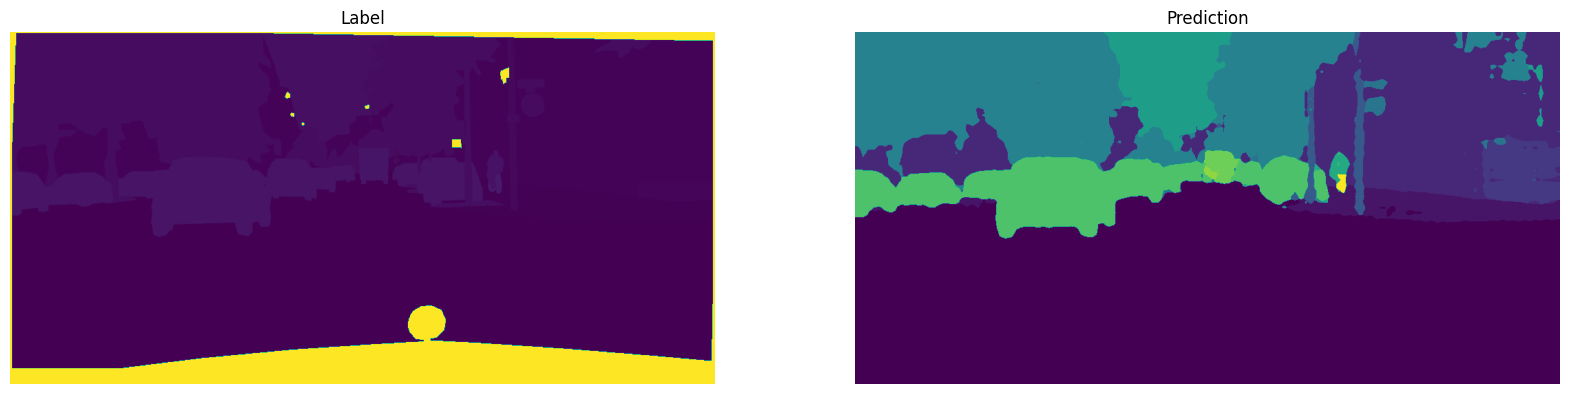

In [10]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
# Set the model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

# Validate the model
# Initialize the hist matrix
hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Break after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### FLOPs and Parameters

In [11]:
# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the number of flops
flops = FlopCountAnalysis(model, image.unsqueeze(0))
# Get the number of flops
flops = flop_count_table(flops)
# Get the number of parameters
params = sum(p.numel() for p in model.parameters())

# Print the number of parameters and flops
print(f'Number of parameters: {params}\n')
print(flops)

Deeplab pretraining loading...
Number of parameters: 43901068

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 0.375T     |
|  conv1                         |  9.408K                |  1.233G    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  16.777M   |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  7.155G    |
|   layer1.0                     |   75.008K              |   2.487G   |
|    layer1.0.conv1              |    4.096K              |    0.136G  |
|    layer1.0.bn1                |    0.128K              |    4.244M  |
|    layer1.0.conv2              |    36.864K             |  

### Latency and FPS

In [12]:
# Set the device
device = torch.device('cuda')   

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.to(device).eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the latency and FPS
iterations = 1000
latency = []
fps = []

# Compute the latency and FPS
for _ in range(iterations):
    start = time()
    model(image.unsqueeze(0).to(device))
    end = time()
    latency.append(end - start)
    fps.append(1 / (end - start))

# Compute the average latency and FPS
mean_latency = np.mean(latency)
mean_fps = np.mean(fps)
std_latency = np.std(latency)
std_fps = np.std(fps)

# Print the latency and FPS
print(f'Latency: {mean_latency:.3f} +/- {std_latency:.3f}')
print(f'FPS: {mean_fps:.3f} +/- {std_fps:.3f}')

Deeplab pretraining loading...
Latency: 0.059 +/- 0.002
FPS: 17.183 +/- 4.556
